In [1]:
import cv2
import math as m
import mediapipe as mp
import numpy as np
import glob
import os

# Initialize MediaPipe pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Directory containing images
image_dir = 'D:/image_dataset/1.jpg'  # Make sure to update this path

# Function to calculate angle
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle

# Function to process an image and detect postures
def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image {image_path}")
        return
    h, w = image.shape[:2]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_image)
    if not results.pose_landmarks:
        print("Pose landmarks not detected.")
        return

    # Draw landmarks for visualization
    mp.solutions.drawing_utils.draw_landmarks(
        image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    landmarks = results.pose_landmarks.landmark

    # Extract necessary landmarks
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x * w,
                     landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y * h]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x * w,
                      landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y * h]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x * w,
                  landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y * h]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x * w,
                   landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y * h]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x * w,
                  landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y * h]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x * w,
                   landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y * h]

    # Calculate angles
    left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)

    # Detect "Crossed Arms" posture
    if 55 <= left_elbow_angle <= 100 and 55 <= right_elbow_angle <= 100:
        cv2.putText(image, "Crossed Arms Detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Detect "Hands Behind the Head" posture
    if (20 <= left_elbow_angle <= 60 and 20 <= right_elbow_angle <= 60):
        cv2.putText(image, "Hands Behind the Head", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

    # Save or display the processed image
    cv2.imwrite(f"processed_{os.path.basename(image_path)}", image)  # Save the processed image

# Iterate over all images in the directory and process them
for image_path in glob.glob(os.path.join(image_dir, '*.png')):  # Adjust the pattern as needed
    process_image(image_path)

cv2.destroyAllWindows()


In [2]:
all_image_paths = []

In [3]:
import cv2
import math as m
import mediapipe as mp
import numpy as np
import glob
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize MediaPipe pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Base directory where the folders are located
base_dir = 'D:/image_dataset/gestures'  # Update this path

# Function to calculate angle
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle

# Modified function to classify an image into a posture
def classify_posture(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image {image_path}")
        return None
    h, w = image.shape[:2]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_image)
    if not results.pose_landmarks:
        return 'NoGesture'
    
    landmarks = results.pose_landmarks.landmark

    # Extract necessary landmarks for angle calculations
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x * w, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y * h]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y * h]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x * w, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y * h]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y * h]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x * w, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y * h]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y * h]

    # Calculate angles for posture detection
    left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)

    # Classify based on angle calculations
    if 55 <= left_elbow_angle <= 100 and 55 <= right_elbow_angle <= 100:
        return 'CrossArms'
    if 20 <= left_elbow_angle <= 60 and 20 <= right_elbow_angle <= 60:
        return 'HandsBehindHead'
    return 'NoGesture'

# Directories and their labels
directories = ['nogesture', 'cross_arms', 'hands_behind_head']
labels = ['NoGesture', 'CrossArms', 'HandsBehindHead']

true_labels = []
predicted_labels = []

# Process each directory
for directory, label in zip(directories, labels):
    image_paths = glob.glob(os.path.join(base_dir, directory, '*.png')) + glob.glob(os.path.join(base_dir, directory, '*.jpg'))  # Update pattern if necessary
    
    for image_path in image_paths:
        predicted_label = classify_posture(image_path)
        true_labels.append(label)
        predicted_labels.append(predicted_label)
        all_image_paths.append(image_path)

# Encode labels
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)




In [4]:
print(classification_report(true_labels_encoded, predicted_labels_encoded, target_names=label_encoder.classes_))

                 precision    recall  f1-score   support

      CrossArms       0.92      0.74      0.82        47
HandsBehindHead       0.93      0.93      0.93        41
      NoGesture       0.75      0.89      0.82        47

       accuracy                           0.85       135
      macro avg       0.87      0.86      0.86       135
   weighted avg       0.86      0.85      0.85       135



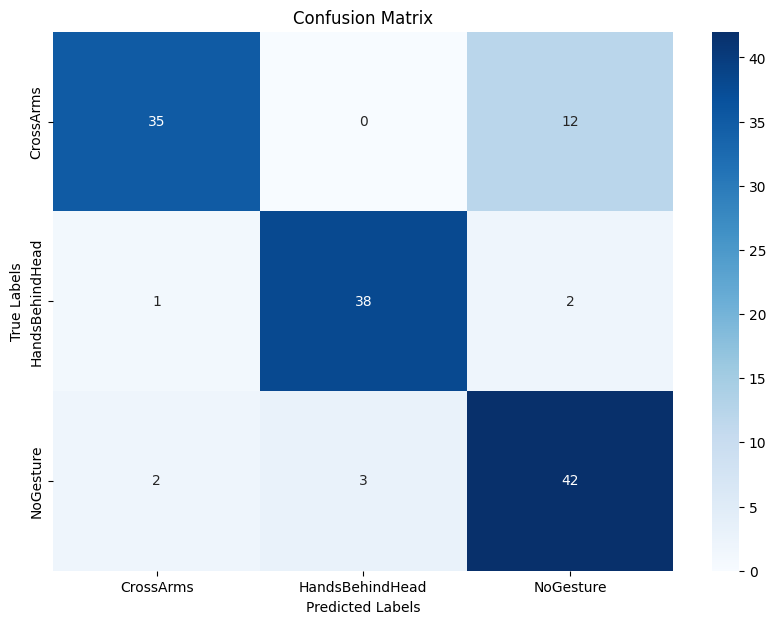

In [5]:
conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels_encoded)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [6]:
# Print out the prediction for each image
print("\nPredictions for each image:")
for true_label, predicted_label, image_path in zip(true_labels, predicted_labels, all_image_paths):
    print(f"{os.path.basename(image_path)}: True - {true_label}, Predicted - {predicted_label}")



Predictions for each image:
1.png: True - NoGesture, Predicted - NoGesture
19.png: True - NoGesture, Predicted - NoGesture
2.png: True - NoGesture, Predicted - NoGesture
22.png: True - NoGesture, Predicted - NoGesture
25.png: True - NoGesture, Predicted - CrossArms
28.png: True - NoGesture, Predicted - NoGesture
2B.png: True - NoGesture, Predicted - CrossArms
3.png: True - NoGesture, Predicted - NoGesture
31.png: True - NoGesture, Predicted - NoGesture
34.png: True - NoGesture, Predicted - NoGesture
36.png: True - NoGesture, Predicted - NoGesture
38.png: True - NoGesture, Predicted - NoGesture
4.png: True - NoGesture, Predicted - NoGesture
40.png: True - NoGesture, Predicted - NoGesture
42.png: True - NoGesture, Predicted - NoGesture
44.png: True - NoGesture, Predicted - NoGesture
46.png: True - NoGesture, Predicted - NoGesture
48.png: True - NoGesture, Predicted - NoGesture
49.png: True - NoGesture, Predicted - NoGesture
5.png: True - NoGesture, Predicted - NoGesture
50.png: True - N

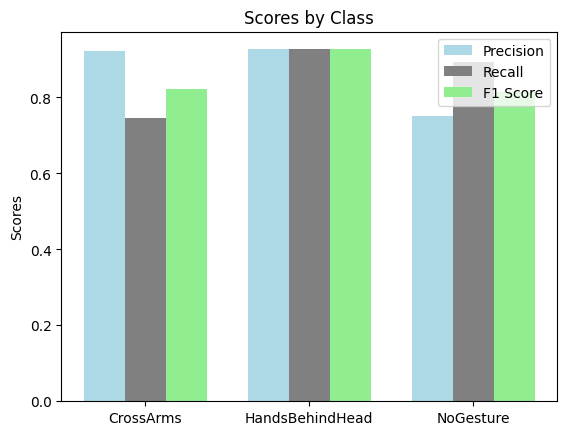

In [11]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

metrics = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None, labels=np.unique(true_labels_encoded))
precision, recall, f1, _ = metrics

# For plotting
categories = label_encoder.classes_

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision', color='lightblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='grey')
rects3 = ax.bar(x + width, f1, width, label='F1 Score', color='lightgreen')


ax.set_ylabel('Scores')
ax.set_title('Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


In [8]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming true_labels_encoded and predicted_labels_encoded are defined elsewhere
# Also assuming label_encoder is already fitted to your classes

metrics = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None, labels=np.unique(true_labels_encoded))
precision, recall, f1, _ = metrics

# Calculate overall accuracy
accuracy = accuracy_score(true_labels_encoded, predicted_labels_encoded)

# For printing metrics by class
categories = label_encoder.classes_

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nScores by Class:")
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f" Precision: {precision[i]:.2f}")
    print(f" Recall: {recall[i]:.2f}")
    print(f" F1 Score: {f1[i]:.2f}\n")


Accuracy: 85.19%

Scores by Class:
Class: CrossArms
 Precision: 0.92
 Recall: 0.74
 F1 Score: 0.82

Class: HandsBehindHead
 Precision: 0.93
 Recall: 0.93
 F1 Score: 0.93

Class: NoGesture
 Precision: 0.75
 Recall: 0.89
 F1 Score: 0.82

